In [21]:
import nodes
import require
import verbose
verbose.set_level( 0 )

country = "Germany"

data_for_country = require.single( "data_for_country" )
crop_to_valid_range = require.single( "crop_to_valid_range" )
df = crop_to_valid_range( data_for_country.get_result( country ))
model = nodes.find( "train_honest_forward" ).get_result( slice( 0, 1 ))

new_deaths_smoothed_per_million


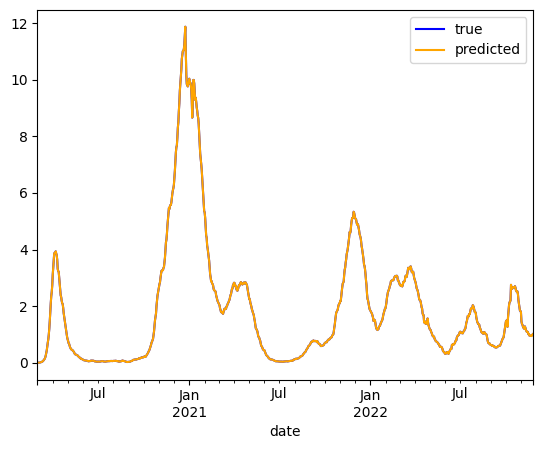

In [23]:
import matplotlib.pyplot as plt

time_range = slice( 0, 1000 )
column = 1

df_pred = model.predict_replace( df )
df.iloc[ time_range, column ].plot( color = "blue" )
df_pred.iloc[ time_range, column ].plot( color = "orange" )

line = lambda color, label: plt.Line2D([ ], [ ], color = color, label = label )
h = [ line( "blue", "true" ), line( "orange", "predicted" )]

plt.legend( handles = h )
print( df_pred.columns[ column ])